# Выбор игры (10)

Студент Петя, который также является стажером в области машинного обучения, решил выбрать себе компьютерную игру на некоторой платформе. Но он решил поступить нестандартно и выбрать игру с помощью машинного обучения. Для этого Петя выгрузил базу отзывов на игры. Чтобы выбрать лучшую игру, нужно эти отзывы классифицировать: понять, какие отзывы положительные, а какие — отрицательные. Помогите Пете это сделать.

Вам дана обучающая выборка данных reviews_train.csv. В ней две колонки:

- id: уникальный идентификатор отзыва;
- review: текст отзыва на игру;
- like: целевая переменная: оценка игры пользователем, написавшим отзыв. 1 - положительная, -1 — отрицательная.
Вам нужно обучить алгоритм машинного обучения, который по тексту отзыва (review) предсказывает значение оценки (like) для отзывов из тестовой выборки reviews_test.csv. В качестве ответа загрузите csv файл с ответами, где для каждого id отзыва из тестового датасета дан ответ: 1 или -1. Пример файла с ответом — sample_submission.csv.

Решение оценивается метрикой F1 (http://bazhenov.me/blog/2012/07/21/classification-performance-evaluation.html). Балл вычисляется по формуле 10s10s, где ss — значение метрики F1.

Данные можно скачать по этой ссылке: https://disk.yandex.ru/d/N4LTf1hFKqkwqA

https://drive.google.com/drive/folders/1SOJIgVOZBaw0M2CbQByAQ_kB-iUJTZum?usp=share_link

## Загрузка данных

In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Монтирует google disk в colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import re
import pandas as pd
import os

url = os.chdir(r"./gdrive/MyDrive/Я-профи подготовка по машинному обучению/игра")
os.getcwd()

'/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/игра'

In [4]:
os.listdir(os.getcwd())

['reviews_train.csv',
 'reviews_test.csv',
 'sample_submission.csv',
 'predictiont14.csv',
 'catboost_info',
 'pred13.csv']

In [5]:
train = pd.read_csv("reviews_train.csv")
test = pd.read_csv("reviews_test.csv")

train

,id,review,like
0,0,This is the kind of game you gift to your frie...,-1
1,1,Early Access Review,1
2,2,"Favourite game ever, must play.",1
3,3,'State of Decay' puts the 'survival' in the zo...,1
4,4,Really good game but you must buy all dlc to r...,1
...,...,...,...
563126,563126,&gt;joins DarkRP server &gt;guy tells me to fo...,1
563127,563127,Fantastic game that ended very quickly. The ch...,1
563128,563128,it's fun try itr out,1
563129,563129,Early Access Review,-1


In [6]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission

,like
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
44995,-1
44996,-1
44997,-1
44998,-1


## Исследование данных

1. Размерность данных
2. Пропуски в данных
3. Что вообще за данные? Что есть в тексте? Какой язык? и т.д.
4. Баланс классов?

In [6]:
# Посмотрим размерность данных
print(train.shape)
print(test.shape)

(563131, 3)
(45000, 2)


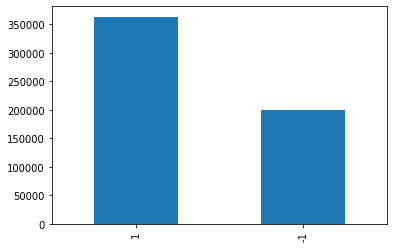

In [7]:
# посмотрим на баланс данных
train['like'].value_counts().plot(kind='bar')

In [8]:
# посмотрим на баланс данных
train['like'].value_counts()

 1    363265
-1    199866
Name: like, dtype: int64

In [9]:
# пропуски в данных
train.isna().sum()

id          0
review    555
like        0
dtype: int64

In [18]:
# пропуски в данных
train_nan = train[train.isna().any(axis=1)]

print(f'Распределение пропусков по классам: \n{train_nan["like"].value_counts()}\n')

train_nan.head()

Распределение пропусков по классам: 
 1    397
-1    158
Name: like, dtype: int64



,id,review,like
718,718,NaN,1
1328,1328,NaN,1
5320,5320,NaN,1
5928,5928,NaN,1
6094,6094,NaN,-1


In [19]:
test.isna().sum()

Unnamed: 0     0
review        39
dtype: int64

## Предварительная обработка данных

In [7]:
# Избавимся от пропусков в данных
train = train.dropna()

train.shape

(562576, 3)

In [8]:
# Проверим теперь наличие пропусков в тренировочно датасете
# Что делать с пропусками в тестовом датасете?
train.isna().sum()

id        0
review    0
like      0
dtype: int64

### Очистка текста

Предварительная обработка и очистка текстовых данных
Любой рабочий процесс анализа данных начинается с их загрузки. Далее мы должны пропустить их через конвейер (pipeline) предобработки:

- удаление знаков препинания, лишних и спец символов
- приведение к одному регистру
- токенизировать текст – разбить текст на предложения, слова и другие единицы;
- удалить стоп-слова;
- работа со словоформами;
- векторизовать тексты – сделать числовые представления текстов для их дальнейшей обработки классификатором.

Все эти шаги служат для уменьшения шума, присущего любому обычному тексту, и повышения точности результатов классификатора. Для решения указанных задач есть несколько отличных библиотек, например, NLTK, TextBlob и spaCy.

**Стоп-слова** – это слова, которые выкидываются из текста до/после обработки текста. Когда мы применяем машинное обучение к текстам, такие слова могут добавить много шума, поэтому необходимо избавляться от нерелевантных слов.

**Стоп-слова** это обычно понимают артикли, междометия, союзы и т.д., которые не несут смысловой нагрузки. При этом надо понимать, что не существует универсального списка стоп-слов, все зависит от конкретного случая.

В NLTK есть предустановленный список стоп-слов. Перед первым использованием вам понадобится его скачать: nltk.download(“stopwords”). После скачивания можно импортировать пакет stopwords и посмотреть на сами слова

In [9]:
%%time

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("english")

def remove_punct(text):
    # удаление пунктуации в тексте
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ',
             40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ',
             47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ',
             64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ',
             123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

def txt_prep(df):
    # функция приводит весь текст к нижнему регистру
    df['review без изменений'] = df['review']
    df['review'] = df['review'].str.lower()
    
    # удаляет пунктуацию
    df['review'] = df['review'].map(lambda x: remove_punct(x))

    # удаляет стоп слова
    df['review'] = df['review'].map(lambda x: x.split(' '))
    df['review'] = df['review'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                    and token != " " \
                                                                    and token.strip() not in punctuation])
    df['review'] = df['review'].map(lambda x: ' '.join(x))

    # удаление ковычек и цифр
    df['review'] = df['review'].str.replace('»', '') 
    df['review'] = df['review'].str.replace('«', '') 
    df['review'] = df['review'].str.replace(r"\d+", '') 

    return df

txt_prep(train)
train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

CPU times: user 1min 55s, sys: 5.35 s, total: 2min 1s
Wall time: 2min 1s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,review,like,review без изменений
0,0,kind game gift friends annoy glitches part gam...,-1,This is the kind of game you gift to your frie...
1,1,early access review,1,Early Access Review
2,2,favourite game ever must play,1,"Favourite game ever, must play."
3,3,state decay puts survival zombie survival genr...,1,'State of Decay' puts the 'survival' in the zo...
4,4,really good game must buy dlc really enjoy,1,Really good game but you must buy all dlc to r...
...,...,...,...,...
563126,563126,gt joins darkrp server gt guy tells follow gt ...,1,&gt;joins DarkRP server &gt;guy tells me to fo...
563127,563127,fantastic game ended quickly choose playstyle ...,1,Fantastic game that ended very quickly. The ch...
563128,563128,fun try itr,1,it's fun try itr out
563129,563129,early access review,-1,Early Access Review


In [10]:
# Заменим -1 на 0, для удобства передачи в классификатор
train.loc[(train.like == -1), 'like'] = 0
train

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,id,review,like,review без изменений
0,0,kind game gift friends annoy glitches part gam...,0,This is the kind of game you gift to your frie...
1,1,early access review,1,Early Access Review
2,2,favourite game ever must play,1,"Favourite game ever, must play."
3,3,state decay puts survival zombie survival genr...,1,'State of Decay' puts the 'survival' in the zo...
4,4,really good game must buy dlc really enjoy,1,Really good game but you must buy all dlc to r...
...,...,...,...,...
563126,563126,gt joins darkrp server gt guy tells follow gt ...,1,&gt;joins DarkRP server &gt;guy tells me to fo...
563127,563127,fantastic game ended quickly choose playstyle ...,1,Fantastic game that ended very quickly. The ch...
563128,563128,fun try itr,1,it's fun try itr out
563129,563129,early access review,0,Early Access Review


### Токенизация текста

**Токенизация** – это процесс разбиения текста на более мелкие части. В библиотеку spaCy уже встроен конвейер (pipeline), который начинает свою работу по обработке текста с токенизации. В этом руководстве мы разделим текст на отдельные слова. Загрузим пример и проведем разбиение:

In [44]:
sentence_data = "The First sentence is about Python. The Second: about Django. You can learn Python,Django and Data Ananlysis here. "
nltk_tokens = nltk.sent_tokenize(sentence_data)
print(nltk_tokens)

['The First sentence is about Python.', 'The Second: about Django.', 'You can learn Python,Django and Data Ananlysis here.']


In [45]:
import nltk

word_data = "It originated from the idea that there are readers who prefer learning new skills from the comforts of their drawing rooms"
nltk_tokens = nltk.word_tokenize(word_data)
print(nltk_tokens)

['It', 'originated', 'from', 'the', 'idea', 'that', 'there', 'are', 'readers', 'who', 'prefer', 'learning', 'new', 'skills', 'from', 'the', 'comforts', 'of', 'their', 'drawing', 'rooms']


### Работа со словоформами

Обычно тексты содержат разные грамматические формы одного и того же слова, а также могут встречаться однокоренные слова. Лемматизация и стемминг преследуют цель привести все встречающиеся словоформы к одной, нормальной словарной форме.

**Стемминг** – это грубый эвристический процесс, который отрезает «лишнее» от корня слов, часто это приводит к потере словообразовательных суффиксов.

**Лемматизация** – это более тонкий процесс, который использует словарь и морфологический анализ, чтобы в итоге привести слово к его канонической форме – лемме.

Отличие в том, что стеммер (конкретная реализация алгоритма стемминга – прим.переводчика) действует без знания контекста и, соответственно, не понимает разницу между словами, которые имеют разный смысл в зависимости от части речи. Однако у стеммеров есть и свои преимущества: их проще внедрить и они работают быстрее. Плюс, более низкая «аккуратность» может не иметь значения в некоторых случаях.

In [35]:
# стемминг
from nltk.stem import PorterStemmer

e_words= ["wait", "waiting", "waited", "waits"]
ps = PorterStemmer()
for w in e_words:
    rootWord=ps.stem(w)
    print(rootWord)

wait
wait
wait
wait


**Лемматизация** — это алгоритмический процесс нахождения леммы слова в зависимости от его значения. Лемматизация обычно относится к морфологическому анализу слов, целью которого является удаление флективных окончаний. Это помогает в возвращении базовой или словарной формы слова, которое известно как лемма. Метод лемматизации NLTK основан на встроенной морф-функции WorldNet. Предварительная обработка текста включает в себя как основы, так и лемматизации. Многие люди находят два термина запутанными. Некоторые относятся к ним как к одним и тем же, но между ними есть разница. Лемматизация предпочтительнее первой по следующей причине.

In [42]:
import nltk
from nltk.stem import WordNetLemmatizer

# создаем модель лемматизатора
wordnet_lemmatizer = WordNetLemmatizer()
text = "studies studying cries cry"

# сначала токенезируем текст
tokenization = nltk.word_tokenize(text)

for w in tokenization:
    print("Lemma for {} is {}".format(w, wordnet_lemmatizer.lemmatize(w)))  

Lemma for studies is study
Lemma for studying is studying
Lemma for cries is cry
Lemma for cry is cry


In [ ]:
!pip install pymorphy2

In [47]:
# Работа с русским текстом
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
p = morph.parse("гуляли")
p

[Parse(word='гуляли', tag=OpencorporaTag('VERB,impf,intr plur,past,indc'), normal_form='гулять', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гуляли', 15, 10),))]

In [48]:
p[0].normal_form

'гулять'

In [54]:
train.head(5)

,id,review,like,review без изменений
0,0,kind game gift friends annoy glitches part gam...,0,This is the kind of game you gift to your frie...
1,1,early access review,1,Early Access Review
2,2,favourite game ever must play,1,"Favourite game ever, must play."
3,3,state decay puts survival zombie survival genr...,1,'State of Decay' puts the 'survival' in the zo...
4,4,really good game must buy dlc really enjoy,1,Really good game but you must buy all dlc to r...


In [52]:
# Лемматизируем наш исходные текст в тренировочном наборе данных
%%time

from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

nrows = len(train.loc[0:2, 'review'])
lemmatized_text_list = []

for row in range(0, nrows):
    # перебираем датафрейм по строкам
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = train.loc[row]['review'] # early access review
    text_words = text.split(" ") # ['early', 'access', 'review'] - список слов всего текста

    # Iterate through every word to lemmatize
    for word in text_words:
        word_norm = wordnet_lemmatizer.lemmatize(word, pos="v")
        lemmatized_list.append(word_norm) # ['early', 'access', 'review']
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list) # early access review
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

lemmatized_text_list

CPU times: user 548 ms, sys: 148 ms, total: 696 ms
Wall time: 753 ms


['kind game gift friends annoy glitches part gameplay  ',
 'early access review',
 'favourite game ever must play']

In [53]:
train.loc[0:2, 'review']

0    kind game gift friends annoy glitches part gam...
1                                  early access review
2                        favourite game ever must play
Name: review, dtype: object

### Векторизация текста

Для решения этой задачи обычно используются разные классификаторы, которые на вход получают вектора, тензоры или матрицы, описыающие текст.

1. Двоичный вектор (0 - нет слова в текста, 1 - есть слово в тексте)
2. Вещественный вектор (описывает встречаемость слов в тексте с учетом их частотности)
3. N-граммы символов и токенов, словосочетания
4. Плотные вектора слов, предожений, текстов (word embading, text embading)
5. Ядерные методы и графовые методы

#### **Двоичный вектор (one-hot encoding/bag of words)**

Преимущества:
- простота
- подходит когда текста отличаются по длине
- размерность вектора очень большая => любые линейные модели хорошо работают

Недостатки:
- чувствителем к шуму
- отсутвует вес слов
- близкие по смыслу слова "кружка" "чашка" распознаются как разные
- низкая способность к обобщению
- большая размерность матрицы

Модель набора слов - это упрощенное представление, используемое при обработке естественного языка и поиске информации (IR). В этой модели текст (например, предложение или документ) представлен как мешок (мультимножество) своих слов, без учета грамматики и даже порядка слов, но с сохранением множественности.

In [31]:
# пример
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
corpus = [
          'Text of first document Text Text.',
          'Text of the second document made longer.',
          'Number three.',
          'This is number four.',
]

X = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())

df_CountVectorizer = pd.DataFrame(data =X.toarray(), columns=vectorizer.get_feature_names())

df_CountVectorizer

['document', 'first', 'four', 'is', 'longer', 'made', 'number', 'of', 'second', 'text', 'the', 'this', 'three']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,document,first,four,is,longer,made,number,of,second,text,the,this,three
0,1,1,0,0,0,0,0,1,0,3,0,0,0
1,1,0,0,0,1,1,0,1,1,1,1,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,1,1,0,0,1,0,0,0,0,1,0


#### **Вещественный вектор (описывает встречаемость слов в тексте с учетом их частотности)**

TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency).

Это простой и удобный способ оценить важность термина для какого-либо документа относительно всех остальных документов. Принцип такой — если слово встречается в каком-либо документе часто, при этом встречаясь редко во всех остальных документах — это слово имеет большую значимость для того самого документа.

Преимущества:
- простота
- очень хорошо описывает особенности тематики документов
- размерность вектора очень большая => любые линейные модели хорошо работают
- хорошо подходит под классификацию тем текстов

Недостатки:
- чувствителем к шуму (опечатки, редкие слова)
- близкие по смыслу слова "кружка" "чашка" распознаются как разные
- низкая способность к обобщению
- большая размерность матрицы

**Term Frequency TF** - это частота слова, то есть на сколько важно слово для текста.

`TF термина а = (Количество раз, когда термин а встретился в тексте / количество всех слов в тексте)`

**Inverse Document Frequency IDF** - измеряет непосредственную важность данного термина для текущего текста. То есть, для TF каждое слово равное по важности в тексте.

`IDF термина а = логарифм(Общее количество документов / Количество документов, в которых встречается термин а)`

**Term Frequency — Inverse Document Frequency**- это умножение TF на IDF и получаем — TF-IDF

`TF-IDF термина а = (TF термина а) * (IDF термина а)`

Мы обходим каждый текст в корпусе текстов, считаем для него TF всех слов, находящихся в нем. Затем для каждого слова считаем IDF и умножаем его на уже посчитанный TF. Полученный словарь (dictionary) мы добавляем в список, чтобы сохранить такой же порядок текстов, какой был на входе. И возвращаем этот список словарей с посчитанными TF-IDF для каждого термина.

In [32]:
# пример
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
          'Text of first document.',
          'Text of the second document made longer.',
          'Number three.',
          'This is number four.',
]

# Создаем модель векторизации текста
vectorizer = TfidfVectorizer()

# токенезация текста и построение словоря
vectorizer.fit(corpus)

# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

{'text': 9, 'of': 7, 'first': 1, 'document': 0, 'the': 10, 'second': 8, 'made': 5, 'longer': 4, 'number': 6, 'three': 12, 'this': 11, 'is': 3, 'four': 2}
[1.51082562 1.91629073 1.91629073 1.91629073 1.91629073 1.91629073
 1.51082562 1.51082562 1.91629073 1.51082562 1.91629073 1.91629073
 1.91629073]


In [33]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names()
print("Feature names", feature_names)

dense = vectors.todense()

denselist = dense.tolist()

df2 = pd.DataFrame(denselist, columns=feature_names)
df2

Feature names ['document', 'first', 'four', 'is', 'longer', 'made', 'number', 'of', 'second', 'text', 'the', 'this', 'three']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,document,first,four,is,longer,made,number,of,second,text,the,this,three
0,0.465809,0.590819,0.000000,0.000000,0.000000,0.000000,0.000000,0.465809,0.000000,0.465809,0.000000,0.000000,0.000000
1,0.325557,0.000000,0.000000,0.000000,0.412928,0.412928,0.000000,0.325557,0.412928,0.325557,0.412928,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.619130,0.000000,0.000000,0.000000,0.000000,0.000000,0.785288
3,0.000000,0.000000,0.525473,0.525473,0.000000,0.000000,0.414289,0.000000,0.000000,0.000000,0.000000,0.525473,0.000000


#### N-граммы

**N-граммы** — это непрерывные последовательности n-элементов в предложении. N может быть 1, 2 или любым другим положительным целым числом.

N-граммы существуют двух видов
- символные
- словные



```
Днем мама мыла раму.
```

- Символьные 3-граммы: дне, нем, ем_ , м_м, _ма, мам
- Словные 2-граммы: днем мама, мама мыла, мыла раму

Для чего используются N-граммы:
- Позволяют сформировать устойчивать к опечаткам.
- N-граммы могут использоваться, когда нам нужно сохранить какую-то последовательность данных, например, какое слово чаще следует за заданным словом.
- Могут использоватся как нормализация текста

Недостатки:
- высокая размерность и разряженность
- близкие по смыслу слова "кружка" "чашка" распознаются как разные
- низкая способность к обобщению

В строенном TfidfVectorizer() есть параметр с помощью которого можно задать N-граммы:

**ngram_range:** tuple (min_n, max_n), по умолчанию = (1, 1)
Нижняя и верхняя границы диапазона извлекаемых n-значений для различных n-граммов. Будут использоваться все значения n, такие что min_n <= n <= max_n. Например, ngram_range из (1, 1) означает только униграммы, (1, 2) означает униграммы и биграммы, а (2, 2) означает только биграммы.

In [34]:
# пример
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
          'Text of first document.',
          'Text of the second document made longer.',
          'Number three.',
          'This is number four.',
]

# Создаем модель векторизации текста
# (1,3)
vectorizer = TfidfVectorizer(ngram_range=(2,2))

# токенезация текста и построение словоря
vectors = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

denselist = dense.tolist()

df2 = pd.DataFrame(denselist, columns=feature_names)
df2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,document made,first document,is number,made longer,number four,number three,of first,of the,second document,text of,the second,this is
0,0.000000,0.617614,0.00000,0.000000,0.00000,0.0,0.617614,0.000000,0.000000,0.486934,0.000000,0.00000
1,0.421765,0.000000,0.00000,0.421765,0.00000,0.0,0.000000,0.421765,0.421765,0.332524,0.421765,0.00000
2,0.000000,0.000000,0.00000,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.000000,0.57735,0.000000,0.57735,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735


In [13]:
df = train.sample(frac=0.5)
print("Исходный размер датасета:" , train.shape)
print("Уменьшанный размер датасета:" , df.shape)

Исходный размер датасета: (562576, 4)
Уменьшанный размер датасета: (281288, 4)


In [15]:
%%time
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

X = df['review']
y = df['like']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

print("Train:", X_train.shape)
print("Test:", X_test.shape)
# # возьмем tf idf
# # Parameter election
ngram_range = (1,2)
max_features = 500

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        min_df=2,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

x_train_2 = tfidf.fit_transform(X_train).todense()
x_test_2 = tfidf.transform(X_test).todense()

Train: (196901,)
Test: (84387,)
CPU times: user 44.8 s, sys: 2.27 s, total: 47.1 s
Wall time: 47.9 s


In [16]:
# чисто для наглядности как работает CountVectorizer
df1 = pd.DataFrame(x_train_2, columns = tfidf.get_feature_names())
df1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,absolutely,access,access review,acting,action,actually,add,adventure,ai,...,worst,worth,would,would recommend,wrong,year,years,yes,yet,zombies
0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.473974,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196896,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
196897,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
196898,0.0,0.0,0.45036,0.456513,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
196899,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
# %%time
# # не буду запускать эту ячейку, так как кончается оперативная память в colab
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer(ngram_range=(3,6), analyzer='word', max_features = 5000)

# X_train_vector = vectorizer.fit_transform(X_train).toarray()
# X_test_vector = vectorizer.transform(X_test).toarray()

In [17]:
print(f'X_train shape after Tf-Idf: {x_train_2.shape}')
print(f'y_train shape after Tf-Idf: {y_train.shape}')

print(f'X_test shape after Tf-Idf: {x_test_2.shape}')
print(f'y_test shape after Tf-Idf: {y_test.shape}')

X_train shape after Tf-Idf: (196901, 500)
y_train shape after Tf-Idf: (196901,)
X_test shape after Tf-Idf: (84387, 500)
y_test shape after Tf-Idf: (84387,)


## Обучение модели

In [ ]:
# %%time
# пример перебора и подбора моделей для обучения
# запускать не буду, много памяти ест

# from sklearn.metrics import classification_report #building a price prediction
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
# from sklearn.svm import SVC

# from sklearn.metrics import confusion_matrix, accuracy_score

# # tfidf
# # x_train_2
# # x_test_2

# log = LogisticRegression()
# xgb = xgb.XGBClassifier()
# rand_tree = RandomForestClassifier()
# svc = SVC()

# models = [log, xgb, rand_tree, svc]

# for model in models:
#     model.fit(x_train_2, y_train)
#     y_pred = model.predict(x_test_2) 

#     print(model)
#     print(accuracy_score(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
#     print('='*100)

In [ ]:
%%time
from sklearn.metrics import classification_report #building a price prediction
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC

# создаем модель классификатора
svc = SVC()

# обучаем модель
svc.fit(x_train_2, y_train)

# предсказываем ответы для теста
y_pred = svc.predict(x_test_2) 

# оцениваем нашу модель
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# обучается овер долго - 30 мин+

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plot_confusion_matrix(svc, X_test, y_test)  
plt.show()

## Подготовка тестового наброра данных и предсказание ответов

In [ ]:
test.isna().sum()
# что делать с пропусками в тесте? удалять нельзя

Unnamed: 0               0
review                  39
review без изменений    39
dtype: int64

In [ ]:
#  заполним пропуски пустой строкой
test['review'] = test['review'].fillna('')

In [ ]:
test.isna().sum()

Unnamed: 0               0
review                   0
review без изменений    39
dtype: int64

In [ ]:
# обработаем тестовый набор также как и тренировочный
txt_prep(test)
test

,Unnamed: 0,review,review без изменений
0,638820,disclaimer i received a review key from th...,**disclaimer** i received a review key from th...
1,644537,early access review,early access review
2,604237,first of all i love dual stick shooters and ...,"first of all, i love dual stick shooters, and ..."
3,670182,love the game so far thanks to steam for givi...,love the game so far. thanks to steam for givi...
4,681107,early access review,early access review
...,...,...,...
44995,576936,everyone else says it broken mechanics same ...,"everyone else says it. broken mechanics, same ..."
44996,621717,whoever gives this game a negative review beca...,whoever gives this game a negative review beca...
44997,637230,my most played game on steam at moment,my most played game on steam at moment! 5/5
44998,689339,my review of infinite well it is a very very g...,my review of infinite well it is a very very g...


In [ ]:
# применим обученый уже алгоритм векторизации текста Tf-Idf
x_test = tfidf.transform(test['review']).todense()

In [ ]:
# предскажем для тестового набора данных ответы
# используя уже обученную модель
y_pred = svc.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
y_pred

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['like'])
y_pred_df.loc[(y_pred_df.like == 0), 'like'] = -1
y_pred_df

,like
0,1
1,1
2,-1
3,1
4,1
...,...
44995,-1
44996,1
44997,1
44998,1


In [ ]:
from google.colab import files

y_pred_df.to_csv('predictiont_game.csv', index=False)

files.download("predictiont_game.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>